<a href="https://colab.research.google.com/github/fathanzys/Data/blob/main/UAS_Datamining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Klasifikasi Kategori BMI dan Rekomendasi Profil Diet Harian Berdasarkan Data NHANES**


**1. Mengapa Menggunakan Model Klasifikasi?**

Tujuan utama proyek ini adalah untuk mengelompokkan individu ke dalam kategori BMI (Body Mass Index): Underweight, Normal, Overweight, dan Obese.

- Karena targetnya adalah label diskrit (kategori) dan bukan nilai kontinu, maka algoritma klasifikasi sangat cocok digunakan.

- Klasifikasi membantu sistem memberikan rekomendasi nutrisi yang dipersonalisasi berdasarkan kategori BMI masing-masing individu.

- Selain itu, klasifikasi medis seperti ini berperan penting dalam deteksi risiko kesehatan sejak dini, seperti obesitas atau kekurangan gizi.


**2. Mengapa Memilih Algoritma Random Forest?**

Random Forest adalah algoritma ensemble yang kuat, menggabungkan banyak decision tree untuk membuat prediksi yang stabil dan akurat.

- Tahan terhadap overfitting karena menggunakan proses bagging dan voting dari banyak pohon keputusan.

- Dapat menangani fitur numerik dan kategorik sekaligus, cocok dengan kompleksitas data NHANES yang beragam (umur, kalori, gula, tekanan darah, dll).

- Memberikan feature importance yang bermanfaat untuk mengidentifikasi faktor-faktor paling berpengaruh terhadap kategori BMI.

- Secara empiris, Random Forest telah terbukti unggul dalam klasifikasi medis karena kemampuannya dalam menangani data non-linear dan interaksi antar variabel.


**3. Mengapa Menganalisis Data NHANES?**

NHANES (National Health and Nutrition Examination Survey) adalah salah satu dataset kesehatan dan nutrisi paling lengkap dan terpercaya, digunakan secara global dalam penelitian epidemiologi.

- Data NHANES menyediakan kombinasi informasi demografis, asupan makanan, kondisi fisik, laboratorium, dan kesehatan yang jarang tersedia dalam satu dataset.

Analisis ini memungkinkan:

- Klasifikasi status gizi populasi

- Deteksi hubungan antara diet (kalori & gula) dan BMI

- Pengembangan rekomendasi nutrisi harian yang berbasis data

- Dengan pendekatan data-driven ini, kebijakan kesehatan dan intervensi gizi bisa diarahkan lebih tepat sasaran berdasarkan hasil analitik.

#**1. Import Library**

###**1.1 Import Library**

Mengimpor semua pustaka Python yang dibutuhkan untuk data preprocessing, pemodelan, evaluasi, dan visualisasi:

pandas, numpy: manipulasi data.

matplotlib, seaborn: visualisasi.

sklearn: training model ML.

SMOTE: penyeimbangan data kategori.

warnings: menyembunyikan peringatan agar output bersih

In [ ]:
# 1. Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

###**1.2 Load Dataset**

Menghubungkan Google Drive dan memuat 6 dataset NHANES: demografi, diet, pemeriksaan fisik, laboratorium, obat, dan kuesioner.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
demographic_data = pd.read_csv("/content/drive/MyDrive/DM/uas/demographic.csv", encoding="latin1")
diet_data = pd.read_csv("/content/drive/MyDrive/DM/uas/diet.csv", encoding="latin1")
examination_data = pd.read_csv("/content/drive/MyDrive/DM/uas/examination.csv", encoding="latin1")
labs_data = pd.read_csv("/content/drive/MyDrive/DM/uas/labs.csv", encoding="latin1")
medications_data = pd.read_csv("/content/drive/MyDrive/DM/uas/medications.csv", encoding="latin1")
questionnaire_data = pd.read_csv("/content/drive/MyDrive/DM/uas/questionnaire.csv", encoding="latin1")

###**1.3 Merge Dataset**

Menggabungkan beberapa dataframe berdasarkan kolom SEQN (ID unik responden) untuk membentuk satu dataframe utama df yang hanya menyimpan kolom-kolom penting seperti usia, gender, kalori, gula, BMI, berat, tinggi, glukosa, dan tekanan darah.

In [ ]:
df = demographic_data[['SEQN', 'RIDAGEYR', 'RIAGENDR']]
df = df.merge(diet_data[['SEQN', 'DR1TKCAL', 'DR1TSUGR']], on='SEQN', how='inner')
df = df.merge(examination_data[['SEQN', 'BMXBMI', 'BMXWT', 'BMXHT']], on='SEQN', how='inner')
df = df.merge(labs_data[['SEQN', 'LBXSGL']], on='SEQN', how='inner')
df = df.merge(questionnaire_data[['SEQN', 'BPQ020']], on='SEQN', how='inner')

In [ ]:
df.head(5)

,SEQN,RIDAGEYR,RIAGENDR,DR1TKCAL,DR1TSUGR,BMXBMI,BMXWT,BMXHT,LBXSGL,BPQ020
0,73557,69,1,1574.0,176.47,26.7,78.3,171.3,554.0,1.0
1,73558,54,1,5062.0,44.99,28.6,89.5,176.8,219.0,1.0
2,73559,72,1,1743.0,102.90,28.9,88.9,175.3,183.0,1.0
3,73560,9,1,1490.0,80.58,17.1,32.2,137.3,NaN,NaN
4,73561,73,2,1421.0,87.78,19.7,52.0,162.4,104.0,1.0


In [ ]:
df.shape

(9813, 10)

#**2. Data Preprocessing**

###**2.1. Data Cleaning**

Menghapus baris yang memiliki nilai kosong (dropna()).

Mengganti nilai 2 menjadi 0 untuk kolom hipertensi agar jadi biner (1: Ya, 0: Tidak).

In [ ]:
df = df.dropna()
df['BPQ020'] = df['BPQ020'].replace({2: 0})


###**2.2. Kategori BMI**

Membuat kolom baru BMI_Category berdasarkan nilai BMXBMI, dengan aturan standar WHO:


1.   < 18.5: Underweight
2.   18.5–24.9: Normal
3.   25–29.9: Overweight
4.   ≥ 30: Obese

@MISC{10665-42330,
	author = {WHO Consultation on Obesity (1999: Geneva, Switzerland) and World Health Organization},
	title = {Obesity : preventing and managing the global epidemic : report of a WHO consultation},
	year = {2000},
	pages = {252 p.},
	series = {WHO technical report series ; 894},
	publisher = {World Health Organization}
}

In [ ]:
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'
df['BMI_Category'] = df['BMXBMI'].apply(categorize_bmi)

###**2.3 Feature Mapping**

Mengganti nama kolom yang tidak intuitif menjadi lebih deskriptif:
Contoh: RIDAGEYR → Age (years), DR1TKCAL → Total Calorie Intake (kcal), dll.

In [ ]:
# 5. Mapping nama fitur ke panjang
feature_map = {
    'RIDAGEYR': 'Age (years)',
    'RIAGENDR': 'Gender (1=Male, 2=Female)',
    'DR1TKCAL': 'Total Calorie Intake (kcal)',
    'DR1TSUGR': 'Sugar Intake (g)',
    'BMXWT': 'Weight (kg)',
    'BMXHT': 'Height (cm)',
    'LBXSGL': 'Fasting Glucose (mg/dL)',
    'BPQ020': 'Diagnosed with Hypertension (1=Yes, 0=No)'
}
df.rename(columns=feature_map, inplace=True)

#**3. Data Transformation**

###**3.1. Feature & Target**

Memisahkan fitur (X) dan target (y):

1. Fitur: data nutrisi, fisiologi, dan hipertensi
2. Target: kategori BMI

In [ ]:
X = df[list(feature_map.values())]
y = df['BMI_Category']

###**3.2. Scaling dan Split**

1. Melakukan standarisasi fitur (StandardScaler) agar skala fitur seragam.
2. Membagi data menjadi data latih dan uji (80:20) dengan stratifikasi berdasarkan kategori BMI.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

###**3.3 SMOTE**

Menerapkan SMOTE (Synthetic Minority Oversampling Technique) untuk mengatasi ketidakseimbangan kelas, khususnya karena data Underweight jumlahnya jauh lebih sedikit.

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

#**4. Data Mining**

###**4.1 Random Forest**

Melatih model Random Forest Classifier dengan 200 pohon dan kedalaman maksimum 12 menggunakan data hasil SMOTE. Kemudian membuat prediksi pada data uji.

In [ ]:
# 9. Random Forest
clf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

#**5. Evaluation**

###**5.1 Classification Report**

Menampilkan metrik evaluasi seperti precision, recall, f1-score, accuracy dari prediksi model terhadap data uji untuk masing-masing kelas BMI.

In [ ]:
print("Classification Report: ")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report: 
              precision    recall  f1-score   support

      Normal       0.93      0.91      0.92       328
       Obese       0.96      0.94      0.95       391
  Overweight       0.87      0.90      0.89       336
 Underweight       0.62      0.80      0.70        20

    accuracy                           0.92      1075
   macro avg       0.85      0.89      0.86      1075
weighted avg       0.92      0.92      0.92      1075

Accuracy: 0.9153488372093024


###**5.2 Confussion Matrix**

Menampilkan heatmap dari confusion matrix untuk menunjukkan distribusi prediksi vs label asli (misal: berapa banyak Normal yang diprediksi sebagai Obese, dll).

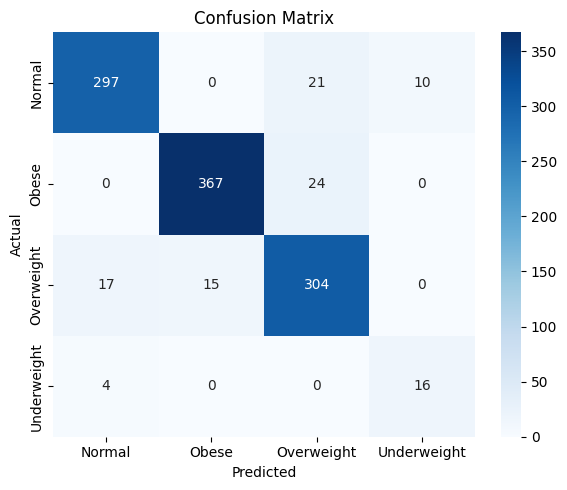

In [ ]:
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

###**5.3 Feature Important**

Menampilkan kontribusi relatif dari setiap fitur terhadap keputusan model menggunakan diagram batang (semakin penting, semakin besar nilainya).

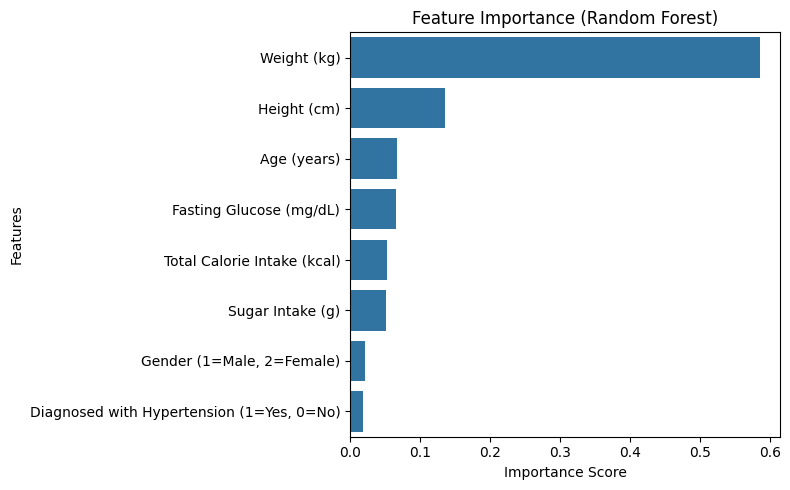

In [ ]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 5))
sns.barplot(x=importances[indices], y=np.array(list(feature_map.values()))[indices])
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

###**5.4 Classification Report Heatmap**

Visualisasi laporan klasifikasi (precision, recall, f1) dalam bentuk heatmap agar lebih mudah dibandingkan antar kelas BMI.

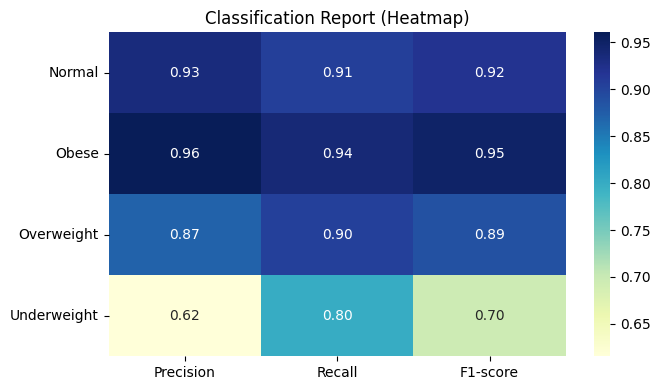

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=clf.classes_)
report_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1-score': f1}, index=clf.classes_)
plt.figure(figsize=(7, 4))
sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title("Classification Report (Heatmap)")
plt.tight_layout()
plt.show()

#**6. Visualisasi/Knowledge Presentation**

###**6.1 Pola Diet**

Menampilkan ringkasan statistik (mean, std, median, min, max) untuk kalori dan gula harian per kategori BMI.

In [ ]:
diet_summary = df.groupby('BMI_Category')[
    ['Total Calorie Intake (kcal)', 'Sugar Intake (g)']
].agg(['mean', 'std', 'median', 'min', 'max'])
print("Ringkasan Pola Diet per Kategori BMI")
print(diet_summary)

Ringkasan Pola Diet per Kategori BMI
             Total Calorie Intake (kcal)                                       \
                                    mean          std  median    min      max   
BMI_Category                                                                    
Normal                       2145.435366  1083.941714  1931.0  360.0  11361.0   
Obese                        2078.475435   993.944114  1916.5  117.0  12108.0   
Overweight                   2141.163192  1013.961087  1981.0  217.0  10293.0   
Underweight                  2236.558824  1018.691809  2122.0  630.0   6805.0   

             Sugar Intake (g)                                    
                         mean        std  median   min      max  
BMI_Category                                                     
Normal             112.862909  83.121628  94.565  0.61  1115.50  
Obese              111.423690  78.659210  95.675  0.13   835.70  
Overweight         109.993228  75.269108  93.360  0.38   587.53  

###**6.2 Distribusi Kalori dan Gula**

Menampilkan dua boxplot:

1. Distribusi kalori harian berdasarkan kategori BMI.

2. Distribusi gula harian berdasarkan kategori BMI.
Visualisasi ini menunjukkan persebaran, outlier, dan median.

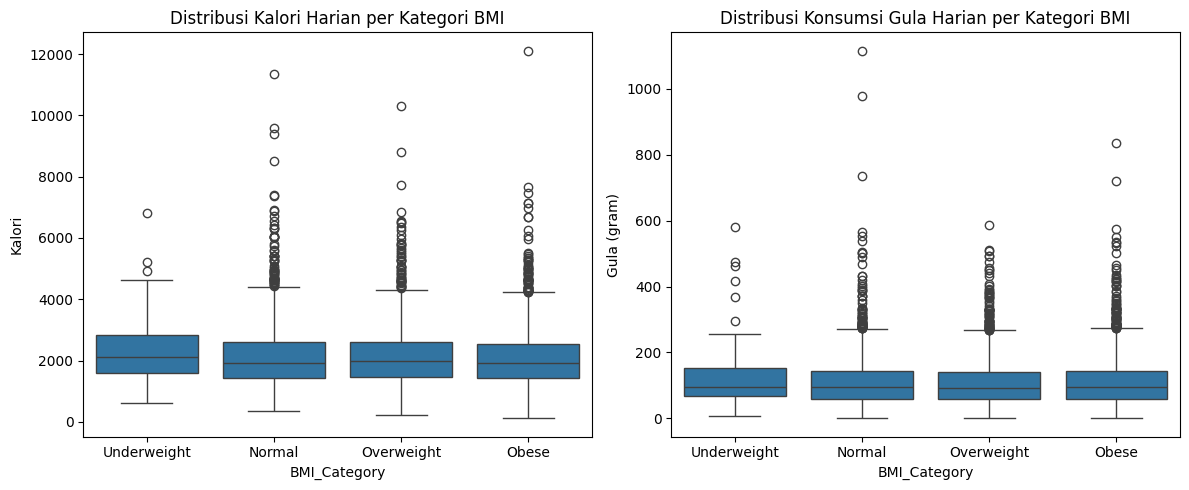

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='BMI_Category', y='Total Calorie Intake (kcal)', data=df, order=['Underweight', 'Normal', 'Overweight', 'Obese'])
plt.title("Distribusi Kalori Harian per Kategori BMI")
plt.ylabel("Kalori")
plt.subplot(1, 2, 2)
sns.boxplot(x='BMI_Category', y='Sugar Intake (g)', data=df, order=['Underweight', 'Normal', 'Overweight', 'Obese'])
plt.title("Distribusi Konsumsi Gula Harian per Kategori BMI")
plt.ylabel("Gula (gram)")
plt.tight_layout()
plt.show()

###**6.3 Korelasi BMI & Kalori**

Visualisasi scatterplot untuk melihat hubungan antara total kalori dengan kategori BMI. Memungkinkan analisis apakah konsumsi kalori berpengaruh terhadap peningkatan berat badan.

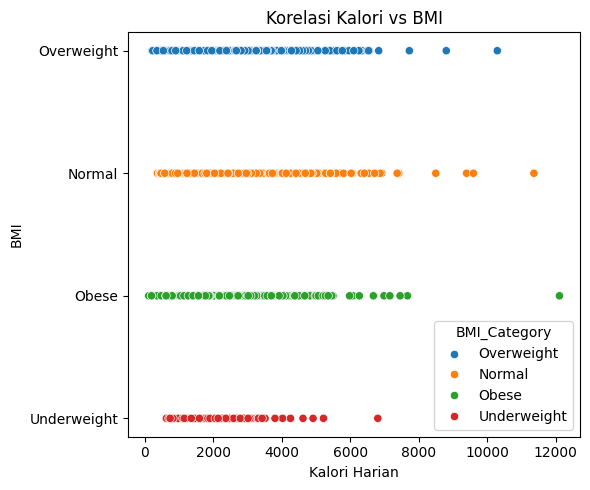

In [ ]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x='Total Calorie Intake (kcal)', y='BMI_Category', hue='BMI_Category', data=df)
plt.title("Korelasi Kalori vs BMI")
plt.xlabel("Kalori Harian")
plt.ylabel("BMI")
plt.tight_layout()
plt.show()

###**6.4 Rata-rata Profile Diet**

1. Menghitung rata-rata kalori, gula, dan glukosa puasa per kategori BMI.

2. Menampilkan visualisasi barplot transpos dari hasil rata-rata tersebut untuk perbandingan antar kategori BMI.

In [ ]:
selected_features = ['Total Calorie Intake (kcal)', 'Sugar Intake (g)', 'Fasting Glucose (mg/dL)']
diet_profile = df.groupby('BMI_Category')[selected_features].mean().round(2)
print("Profil Diet Rekomendasi Harian (Rata-rata)")
display(diet_profile)

Profil Diet Rekomendasi Harian (Rata-rata)


,Total Calorie Intake (kcal),Sugar Intake (g),Fasting Glucose (mg/dL)
BMI_Category,,,
Normal,2145.44,112.86,93.45
Obese,2078.48,111.42,110.72
Overweight,2141.16,109.99,102.96
Underweight,2236.56,122.39,91.09


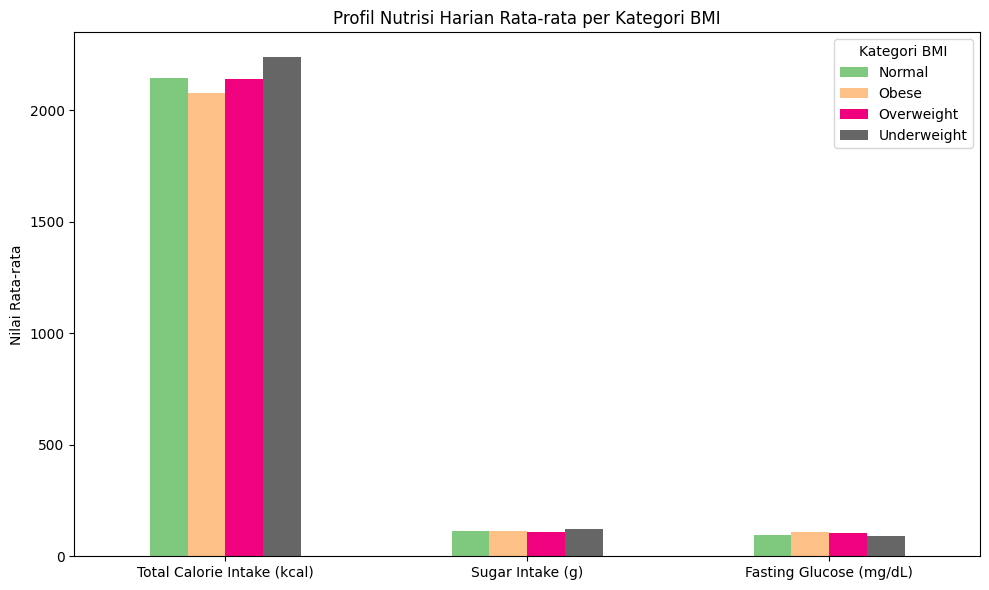

In [ ]:
diet_profile.T.plot(kind='bar', figsize=(10, 6), colormap='Accent')
plt.title("Profil Nutrisi Harian Rata-rata per Kategori BMI")
plt.ylabel("Nilai Rata-rata")
plt.xticks(rotation=0)
plt.legend(title="Kategori BMI")
plt.tight_layout()
plt.show()

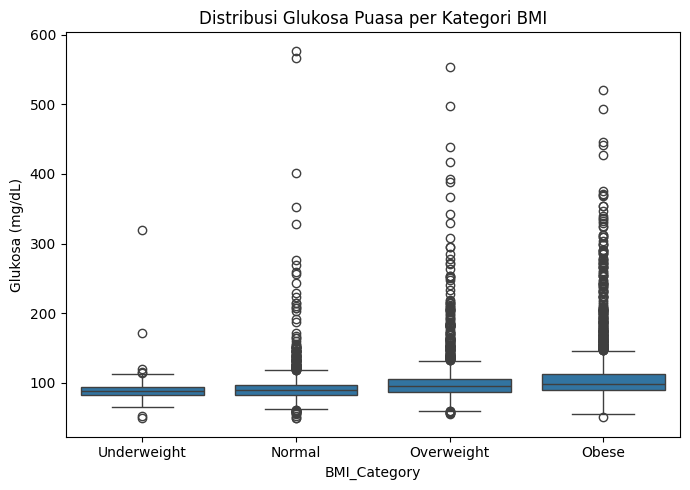

In [ ]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='BMI_Category', y='Fasting Glucose (mg/dL)', data=df, order=['Underweight', 'Normal', 'Overweight', 'Obese'])
plt.title("Distribusi Glukosa Puasa per Kategori BMI")
plt.ylabel("Glukosa (mg/dL)")
plt.tight_layout()
plt.show()

In [ ]:
df.head(5)

,SEQN,Age (years),"Gender (1=Male, 2=Female)",Total Calorie Intake (kcal),Sugar Intake (g),BMXBMI,Weight (kg),Height (cm),Fasting Glucose (mg/dL),"Diagnosed with Hypertension (1=Yes, 0=No)",BMI_Category
0,73557,69,1,1574.0,176.47,26.7,78.3,171.3,554.0,1.0,Overweight
1,73558,54,1,5062.0,44.99,28.6,89.5,176.8,219.0,1.0,Overweight
2,73559,72,1,1743.0,102.90,28.9,88.9,175.3,183.0,1.0,Overweight
4,73561,73,2,1421.0,87.78,19.7,52.0,162.4,104.0,1.0,Normal
5,73562,56,1,1785.0,81.75,41.7,105.0,158.7,104.0,1.0,Obese
